In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


9. Read the pytorch tutorial to use a pre-trained “ConvNet as fixed feature extractor” from https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html and you can ignore “finetuning the ConvNet”. Test this code out to see if it runs properly in your environment after eliminating code blocks that you do not need. [2]

In [2]:
from __future__ import print_function, division
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
import torchvision.models as models
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
cudnn.benchmark = True
plt.ion()

Data Loader

In [ ]:
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = '/content/drive/MyDrive/data/hymenoptera_data'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=2)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
print(dataset_sizes)
class_names = image_datasets['train'].classes
print(class_names)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

{'train': 244, 'val': 153}
['ants', 'bees']
cpu


Data Visualisation

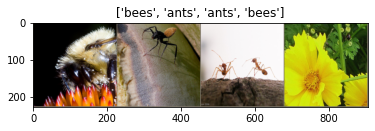

In [ ]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

Model Training

In [ ]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:4f}')

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

Model Visualisation

In [ ]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title(f'predicted: {class_names[preds[j]]}')
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

Using ConvNet as a Feature Extractor

In [ ]:
model_conv = torchvision.models.resnet18(pretrained=True)
for param in model_conv.parameters():
    param.requires_grad = False

num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, 2)

model_conv = model_conv.to(device)

criterion = nn.CrossEntropyLoss()

optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum=0.9)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

Now the Model can be trained on the extracted features

In [ ]:
model_conv = train_model(model_conv, criterion, optimizer_conv, exp_lr_scheduler, num_epochs=25)

Epoch 0/24
----------
train Loss: 0.7456 Acc: 0.5861
val Loss: 0.4823 Acc: 0.7124

Epoch 1/24
----------
train Loss: 0.4672 Acc: 0.7910
val Loss: 0.1859 Acc: 0.9477

Epoch 2/24
----------
train Loss: 0.4065 Acc: 0.8115
val Loss: 0.1700 Acc: 0.9477

Epoch 3/24
----------
train Loss: 0.4848 Acc: 0.8156
val Loss: 0.2070 Acc: 0.9412

Epoch 4/24
----------
train Loss: 0.3908 Acc: 0.8402
val Loss: 0.1755 Acc: 0.9477

Epoch 5/24
----------
train Loss: 0.4500 Acc: 0.8156
val Loss: 0.2823 Acc: 0.8824

Epoch 6/24
----------
train Loss: 0.4740 Acc: 0.7951
val Loss: 0.1955 Acc: 0.9412

Epoch 7/24
----------
train Loss: 0.3692 Acc: 0.8238
val Loss: 0.1941 Acc: 0.9477

Epoch 8/24
----------
train Loss: 0.3253 Acc: 0.8443
val Loss: 0.1963 Acc: 0.9412

Epoch 9/24
----------
train Loss: 0.3770 Acc: 0.8361
val Loss: 0.1948 Acc: 0.9477

Epoch 10/24
----------
train Loss: 0.3054 Acc: 0.8770
val Loss: 0.2139 Acc: 0.9281

Epoch 11/24
----------
train Loss: 0.4052 Acc: 0.8320
val Loss: 0.2020 Acc: 0.9346

Ep

Finally the model can be visualised as follows

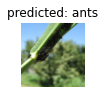

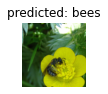

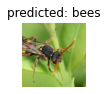

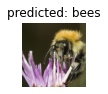

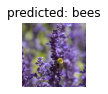

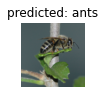

In [ ]:
visualize_model(model_conv)

plt.ioff()
plt.show()

10. Write a function that outputs ResNet18 features for a given input image. Extract features for training images (in image_datasets['train']). You should get an Nx512 dimensional array. [2]

Below Function extracts the features from images and therir corresponding labels from the given data path.


In [3]:
def Extract_Resnet18_Features(data_path):
    # Define the pretrained  ResNet18 model on Imagenet Dataset
    resnet18 = models.resnet18(pretrained=True)

    # Remove the last fully connected layer as we are using it just for the purpose of feature extraction
    resnet18 = torch.nn.Sequential(*list(resnet18.children())[:-1])

    # Set the model to evaluation mode
    # to do a forward pass
    # and ensure all nodes are active 
    resnet18.eval()

    # Define the image transformations
    # Image Transformations resize, crop, & normalise the images by dividing it with Imagenet Mean
    # conerting it into a tensor
    transform = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

    # Load the images from the given data path and apply  the  transform 
    dataset = ImageFolder(data_path, transform)

    # Load the data into the pytorch data loader
    loader = DataLoader(dataset, batch_size=32, shuffle=False)

    # Now features and labels are extracted and stored in arrays
    # Extract features from each image and store them in a matrix
    # With the accompanying Label of the Image
    features = []
    labels = []

    # itaerate over the entire image dataset 
    with torch.no_grad():
        for images, batch_labels in loader:
            # apply resnet on an image
            batch_features = resnet18(images).squeeze()
            # add the extracted features & labels to the arrays
            features.append(batch_features)
            labels.append(batch_labels)
    features = torch.cat(features, dim=0)
    labels = torch.cat(labels, dim=0)

    # Function returns a Matrix of features along with corresponding Labels for each Image
    return features.numpy(), labels.numpy()

In [4]:
# Featur Extraction from the train folder
X_train, y_train = Extract_Resnet18_Features("/content/drive/MyDrive/data/hymenoptera_data/train")

/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

In [5]:
# Conerting the features extacted to a Pandas DataFrame
import pandas as pd

X_train = pd.DataFrame(X_train)
y_train = pd.DataFrame(y_train)
X_train.shape, y_train.shape

((244, 512), (244, 1))

In [6]:
# Extracting the val features
X_val, y_val = Extract_Resnet18_Features("/content/drive/MyDrive/data/hymenoptera_data/val")

/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [7]:
# Conerting them to the Data Frame
X_val = pd.DataFrame(X_val)
y_val = pd.DataFrame(y_val)
X_val.shape, y_val.shape

((153, 512), (153, 1))

11. Compare L2 regularized logistic regression, RBF kernel SVM (do grid search on kernel width and regularization), and random forest (do grid search on max depth and number of trees). Test the final model on test data and show the results -- accuracy and F1 score. [3]

L2 regularized logistic regression model on the extracted ResNet18 features

Validation accuracy: 0.9673
              precision    recall  f1-score   support

           0       0.96      0.97      0.96        70
           1       0.98      0.96      0.97        83

    accuracy                           0.97       153
   macro avg       0.97      0.97      0.97       153
weighted avg       0.97      0.97      0.97       153



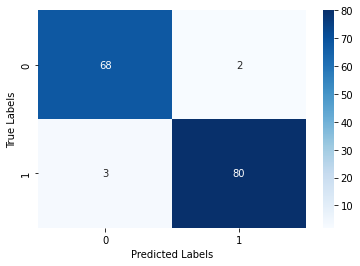

In [8]:
# we can now apply L2 Log Regression to classify images 

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# define L2 Log Regression & apply on train set
L2_LR = LogisticRegression(penalty="l2", C=1.0, max_iter=1000)
L2_LR.fit(X_train, np.ravel(y_train))

# predict the perfoemnce on val set
y_pred = L2_LR.predict(X_val)
acc = accuracy_score(y_val, y_pred)

# the accuracy, calassificatio report, confusoin matrix are plotted as follows
print(f"Validation accuracy: {acc:.4f}")
print(classification_report(y_val, y_pred))

cm = confusion_matrix(y_val, y_pred)
sns.heatmap(cm, annot=True, cmap="Blues", fmt="d")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

RBF kernel SVM (do grid search on kernel width and regularization),

Best parameters: {'C': 0.1, 'gamma': 0.001}
Validation accuracy: 0.9542
              precision    recall  f1-score   support

           0       0.93      0.97      0.95        70
           1       0.97      0.94      0.96        83

    accuracy                           0.95       153
   macro avg       0.95      0.96      0.95       153
weighted avg       0.96      0.95      0.95       153



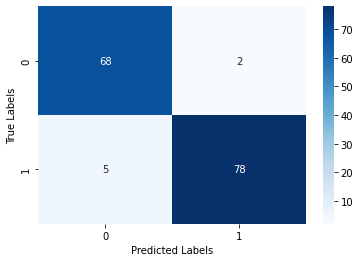

In [9]:
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV

param_grid = {
    "C": [0.001, 0.01, 0.1, 0.5, 0.1],
    "gamma": [0.001, 0.01, 0.1, 0.5, 1.0],
}

# Defien the SVM Classifier
RBF_SVM = SVC(kernel="rbf")

# Perform Grid Search 
grid = GridSearchCV(RBF_SVM, param_grid, cv=5, n_jobs=-1)
grid.fit(X_train,  np.ravel(y_train))


# Evaluate the RBF Kernel SVM on the validation set
y_pred = grid.predict(X_val)
acc = accuracy_score(y_val, y_pred)

# the best params, accuracy, calassificatio report, confusoin matrix are plotted as follows
print(f"Best parameters: {grid.best_params_}")
print(f"Validation accuracy: {acc:.4f}")
print(classification_report(y_val, y_pred))

cm = confusion_matrix(y_val, y_pred)
sns.heatmap(cm, annot=True, cmap="Blues", fmt="d")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

Random forest (do grid search on max depth and number of trees).

Best parameters: {'max_depth': 10, 'n_estimators': 200}
Validation accuracy: 0.9412
              precision    recall  f1-score   support

           0       0.94      0.93      0.94        70
           1       0.94      0.95      0.95        83

    accuracy                           0.94       153
   macro avg       0.94      0.94      0.94       153
weighted avg       0.94      0.94      0.94       153



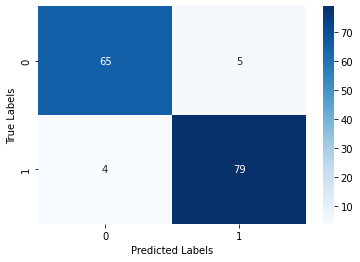

In [10]:
from sklearn.ensemble import RandomForestClassifier

param_grid = {'max_depth': [10, 20, 30, 40, 50],
              'n_estimators': [50, 100, 150, 200, 250]}

# Define the random forest classifier
RFC = RandomForestClassifier(random_state=42)

# Perform grid search to find the best hyperparameters
grid = GridSearchCV(RFC, param_grid=param_grid, cv=5)
grid.fit(X_train, np.ravel(y_train))

# Evaluate the random forest classifier on the validation set
y_pred = grid.predict(X_val)
acc = accuracy_score(y_val, y_pred)

# the best params, accuracy, calassificatio report, confusoin matrix are plotted as follows
print(f"Best parameters: {grid.best_params_}")
print(f"Validation accuracy: {acc:.4f}")
print(classification_report(y_val, y_pred))

cm = confusion_matrix(y_val, y_pred)
sns.heatmap(cm, annot=True, cmap="Blues", fmt="d")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

12. Summarize your findings and write your references. [2]


Findings

The features with misisng values in the dataste must be droped or imputed if fewer in nunmber.

The featuers that dont show any signiifant variance  throughout the dastaset ca n alos be dropped from the model.

Simlarly teh features that are hihgly interdependent, which ahve a high covariacne are also dropped in the process.

Subsequenty the labesl are encoded & the data is normalized using Standard Scalsaer or Min Max Scaler

Cross validation usng Grid Searhc was perfoemd on the part og the training dataset to find the best hyperparams on whuch teh entire model was then trainde.

Feature Importnacme was use d to find the relative impotrncaec of the featiues in each model. 
It can be observed that differnt featiures are imptortatn for differnety calassisficaton tasks. 
However for the same classification tasks across differmet models some of the imorptant features may be commmon. 

RFECV was perfomred on the Linear SVM and Random Forest to eliminate the features recurively that dont have significant contribution to the accuracy.

While for the RBF Kernel SVM and Neural Network, RFECV can not as such be used, as none of these estimators have an underlying coefficient or feature importnmce metric.

Hence for RBF Kernel SVM and Neural Networks the important features are selected as returned by the Feature Importance evaluation performed using Permutation Importance.

Later on the selected features either from RFECV or permutaion importamce, new models are trained and tested.

These models built on fewer features show similar or better performace to those tested earlier on the larger set of features.


Feature Extarctoin from images was performed using resnet, by doing a forwaxd pass thriugh a trained resnet 18 model.
The last layer in the model is removed to extract the 512 featurds corresponfing to the image.

The same is performed on all the images in the train & val set.
The features are stored along with labels in a datatfraem on which difefrmt models are appleid to perform d the classificton task rwquired.

The clssificatojn task perforemd was done with grid search to look for the best params on hich teh mdoel was then trained. 

All gthe models were followed by a classificatioknn report and a confusion matric x to understand the perfromance og f the Classifiction model.


References.

1. 6.4. Imputation of missing values¶ https://scikit-learn.org/stable/modules/impute.html

2. Recursive Feature Elimination using sklearn.feature_selection.RFECV¶  https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.RFECV.html

3. TRANSFER LEARNING FOR COMPUTER VISION TUTORIAL https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html 

4. Exploratory Data Analysis(EDA): Python https://towardsdatascience.com/exploratory-data-analysis-eda-python-87178e35b14

5. How to identify the right independent variables for Machine Learning Supervised Algorithms? https://towardsdatascience.com/how-to-identify-the-right-independent-variables-for-machine-learning-supervised-algorithms-439986562d32